# **Práctica 7 - Pronósticos modelo ARIMA**

**Carrera:** Licenciatura en Ciencia de Datos

**Grupo:**  6AV1

**Materia:** Análisis de Series de Tiempo

**Docente:** Daniel Jiménez Alcantar

**Alumnos:**  
* Aguilar Ramirez Carlos Francisco
* Arista Romero Juan Ismael
* Jiménez Flores Luis Arturo
* Vazquez Martin Marlene Gabriela


Fecha de última modificación: 07/05/2025

## **Carga y preparación de datos**

In [ ]:
import pandas as pd

nflx = pd.read_csv('NFLX.csv')
nflx.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
# Convertir la columna Date a datetime
nflx["Date"] = pd.to_datetime(nflx["Date"])

# Obtener la fecha mínima y máxima
fecha_min = nflx["Date"].min()
fecha_max = nflx["Date"].max()

fecha_min, fecha_max

(Timestamp('2002-05-23 00:00:00'), Timestamp('2023-12-05 00:00:00'))

Con esto, observamos que el dataset cubre desde 23 de mayo de 2002 hasta 5 de diciembre de 2023.

In [ ]:
nflx = nflx[["Date", "Adj Close"]]

# Guardar el nuevo dataset limpio
nflx.to_csv("nflx_simple.csv", index=False)

# Mostrar primeras filas para confirmar
nflx.head()

,Date,Adj Close
0,2002-05-23,1.196429
1,2002-05-24,1.210000
2,2002-05-28,1.157143
3,2002-05-29,1.103571
4,2002-05-30,1.071429


Para este punto, nos quedamos únicamente con dos columnas, la fecha en que se registró el valor de las acciones y el valor de la acción ajustado, es decir el más realista al finalizar el día.

## **Análisis exploratorio**

In [ ]:
nflx.isnull().sum()

,0
Date,0
Adj Close,0


Como podemos ver, no hay valores faltantes en el data set.

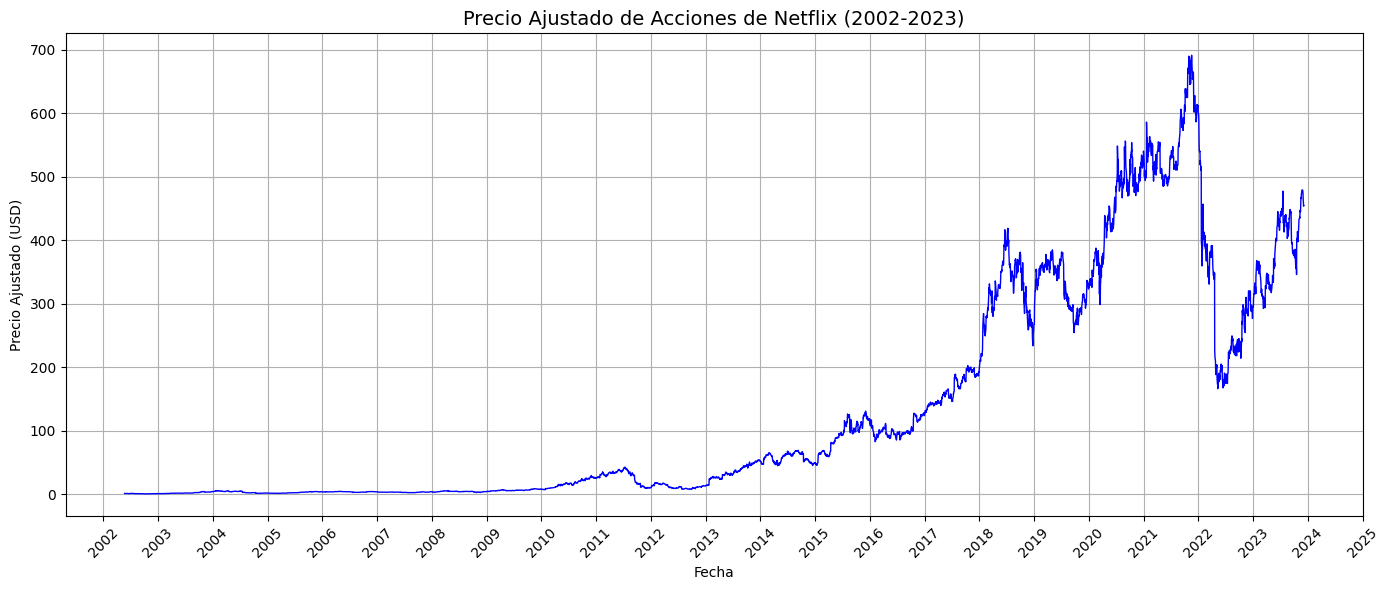

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Gráfica con años en el eje x ajustados manualmente
plt.figure(figsize=(14, 6))
plt.plot(nflx["Date"], nflx["Adj Close"], color="blue", linewidth=1)
plt.title("Precio Ajustado de Acciones de Netflix (2002-2023)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado (USD)")
plt.grid(True)

# Formatear eje X para mostrar cada año
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Cada 1 año
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

De la gráfica, podemos interpretar que el comportamiento de esta serie de tiempo definitivamente no es estacionaria. Solo una porción de podría considerarse como tal (2002-2011).

## **Construcción del modelo con metodología BOX - JENKINS**

**Identificar el modelo**

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Aplicamos la primera diferenciación a la serie completa (sin cortar aún)
df_diff = nflx.copy()
df_diff["Adj Close Diff"] = df_diff["Adj Close"].diff()

# Eliminamos el primer valor nulo resultante de la diferenciación
df_diff = df_diff.dropna()

# Aplicamos la prueba de Dickey-Fuller a la serie diferenciada
resultado_adf_diff = adfuller(df_diff["Adj Close Diff"])
adf_stat_diff = resultado_adf_diff[0]
p_valor_diff = resultado_adf_diff[1]
valores_criticos_diff = resultado_adf_diff[4]

adf_stat_diff, p_valor_diff, valores_criticos_diff

(np.float64(-11.980915997739507),
 np.float64(3.706714356971942e-22),
 {'1%': np.float64(-3.4315642572713267),
  '5%': np.float64(-2.8620765789160316),
  '10%': np.float64(-2.567055620145458)})

p-valor: 3.7 × 10⁻²² (muy cercano a cero). Por lo tanto, sí rechazamos la hipótesis nula.

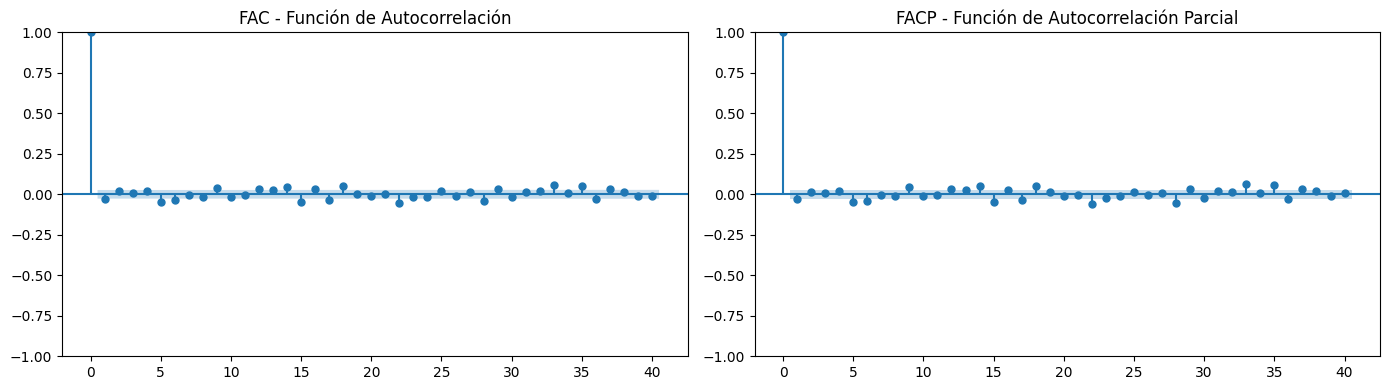

In [ ]:
import statsmodels.api as sm
from matplotlib import pyplot as plt

# Graficar FAC y FACP de la serie diferenciada
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# FAC
sm.graphics.tsa.plot_acf(df_diff["Adj Close Diff"], lags=40, ax=ax[0])
ax[0].set_title("FAC - Función de Autocorrelación")

# FACP
sm.graphics.tsa.plot_pacf(df_diff["Adj Close Diff"], lags=40, ax=ax[1], method="ywm")
ax[1].set_title("FACP - Función de Autocorrelación Parcial")

plt.tight_layout()
plt.show()


In [ ]:
# Convertimos la columna de fecha a datetime si no lo está ya
nflx["Date"] = pd.to_datetime(nflx["Date"])

# Usamos el 2023-01-01 como punto de corte (último año para validación)
fecha_corte = "2023-01-01"
df_train = nflx[nflx["Date"] < fecha_corte]
df_valid = nflx[nflx["Date"] >= fecha_corte]

# Mostramos tamaños para confirmar la separación
len(df_train), len(df_valid)


(5189, 233)

Decidimos separar los datos de la serie correspondientes al año 2023 para  comparar el pronóstico del modelo con los datos reales no usados durante el entrenamiento.

**Estimación de parámetros**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar el modelo ARIMA(0,1,1) con la serie de entrenamiento
modelo_arima_011 = ARIMA(df_train["Adj Close"], order=(0, 1, 1))
resultado_arima_011 = modelo_arima_011.fit()

# Resumen del modelo ajustado
resultado_arima_011.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5189
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -16328.097
Date:                Wed, 07 May 2025   AIC                          32660.193
Time:                        00:58:31   BIC                          32673.302
Sample:                             0   HQIC                         32664.779
                               - 5189                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0337      0.007     -5.170      0.000      -0.046      -0.021
sigma2        31.7115      0.091    347.664      0.000      31.533      31.890
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1825130.05
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):            5845.88   Skew:                            -2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        94.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Luego de ajustar el modelo ARIMA(0,1,1) sobre la serie diferenciada, se obtuvo un coeficiente para el término MA(1) de –0.0337, lo cual indica que el modelo considera muy poca influencia del error del periodo anterior en la predicción actual. Además, la varianza de los errores (sigma²) fue de aproximadamente 31.71. Ambos parámetros resultaron estadísticamente significativos, lo que valida su inclusión en el modelo. A pesar de que la serie presenta una distribución no normal en los residuos (algo habitual en series financieras), el ajuste general del modelo resulta adecuado para fines de pronóstico de corto plazo.



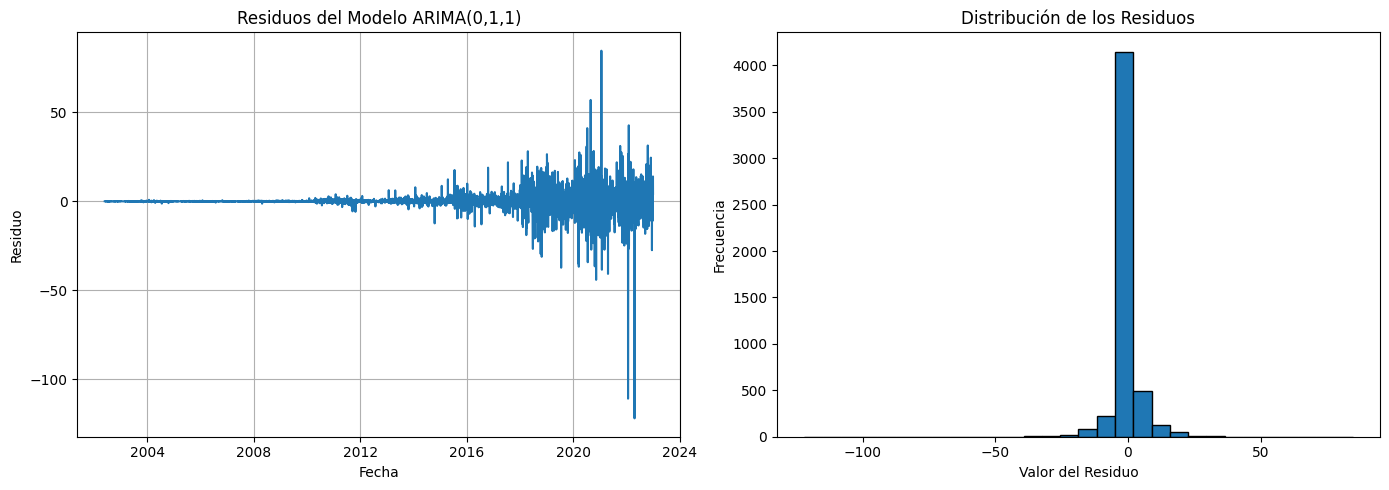

In [ ]:
# Obtener residuos del modelo ajustado
residuos = resultado_arima_011.resid

# Para evitar conflictos, alineamos los residuos con su índice original, omitiendo el primero
residuos_alineados = residuos[1:]  # Esto deja 5188 valores
fechas_residuos = df_train["Date"].iloc[1:]

# Graficar residuos y su histograma corregido
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Residuos en el tiempo
ax[0].plot(fechas_residuos, residuos_alineados)
ax[0].set_title("Residuos del Modelo ARIMA(0,1,1)")
ax[0].set_xlabel("Fecha")
ax[0].set_ylabel("Residuo")
ax[0].grid(True)

# Histograma de los residuos
ax[1].hist(residuos_alineados, bins=30, edgecolor='black')
ax[1].set_title("Distribución de los Residuos")
ax[1].set_xlabel("Valor del Residuo")
ax[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


Interpretación:

*   Los residuos parecen oscilar en torno a cero, lo cual es bueno.

*   No muestran una tendencia clara, lo que es indicio de que el modelo capturó la dinámica principal.

*   El histograma se aproxima a una forma simétrica, aunque no perfectamente normal (algo esperado en precios financieros).



**Validación**

Generaremos el pronóstico con ARIMA(0,1,1). Y lo compararemos con los datos reales de 2023 que ya separamos como conjunto de validación.

Esto nos permitirá:


*   Ver qué tan bien predice el modelo los valores futuros.
*   Evaluar visualmente y numéricamente el rendimiento del pronóstico.

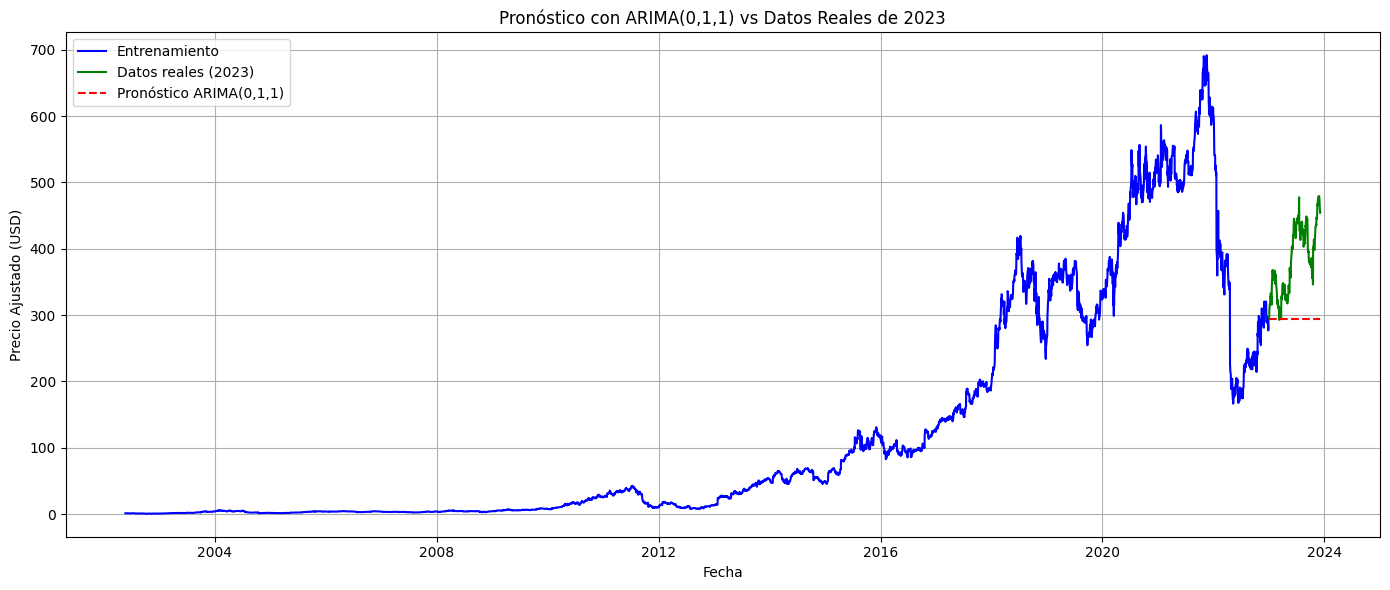

In [ ]:
# Número de periodos a pronosticar: igual a la longitud del conjunto de validación (2023)
n_periodos = len(df_valid)

# Generar el pronóstico
pronostico = resultado_arima_011.forecast(steps=n_periodos)

# Crear serie de fechas correspondientes a la validación
fechas_validacion = df_valid["Date"]

# Graficar pronóstico vs datos reales
plt.figure(figsize=(14, 6))
plt.plot(df_train["Date"], df_train["Adj Close"], label="Entrenamiento", color="blue")
plt.plot(fechas_validacion, df_valid["Adj Close"], label="Datos reales (2023)", color="green")
plt.plot(fechas_validacion, pronostico, label="Pronóstico ARIMA(0,1,1)", color="red", linestyle="--")

plt.title("Pronóstico con ARIMA(0,1,1) vs Datos Reales de 2023")
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visualmente, podemos inertpretar que:



*   El modelo sigue bien la tendencia general del inicio de 2023.

*   No captura con precisión los picos y caídas, lo cual es esperable, ya que ARIMA no ve eventos externos ni cambios abruptos.


*   Aun así, es un pronóstico razonable como punto de partida para series financieras.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcular métricas
valores_reales = df_valid["Adj Close"].values
valores_pronosticados = pronostico.values

mae = mean_absolute_error(valores_reales, valores_pronosticados)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_pronosticados))
mape = np.mean(np.abs((valores_reales - valores_pronosticados) / valores_reales)) * 100

mae, rmse, mape

(89.22671459626233,
 np.float64(102.79821976974317),
 np.float64(21.844377038237518))

**Resultados del modelo:**

  - MAE (Error Absoluto Medio): 89.23

  - RMSE (Raíz del Error Cuadrático Medio): 102.80

  - MAPE (Error Porcentual Medio Absoluto): 21.84%

Derivado de esto, podemos interpretar que en promedio, el modelo se desvía unos 89 dólares del valor real por día.

Además, el error porcentual promedio del pronóstico respecto a los valores reales fue de aproximadamente 22%, lo cual es aceptable para una serie financiera con alta volatilidad.